### Imports

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

#### Paths

In [7]:
RAW_DATA_PATH = '/home/jupyter/raw_data/'
DATA_PATH = '/home/jupyter/data/'

FRAME_PATH = os.path.join(os.getcwd(), 'images')  # .jpg
MASK_PATH = os.path.join(os.getcwd(), 'labels')  # .txt
METADATA_PATH = os.path.join(os.getcwd(), 'metadata') # .txt

# YOLOv3 config file directory
CONFIG_PATH = os.path.join(os.getcwd(), 'cfg')

# YOLOv3 training weights will be saved here
BACKUP_PATH = os.path.join(os.getcwd(), 'backup') #.weights

DATA_EXTENSION_FILE_PATH = os.path.join(CONFIG_PATH, 'ih_fp.data')


### Loss

Running the following code we can check how the train is going while still running and also check loss once finished (reeds train_log.text)

In [ ]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

print(i)
print(max(iters))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 1.5])
plt.xlim([max(iters)/1.5,max(iters)])

#### IOU

When working with images there are two performce metrics you can use. One is mAP and the other one is IOU (interface over union) here we used IOU

https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Text(0, 0.5, 'IOU')

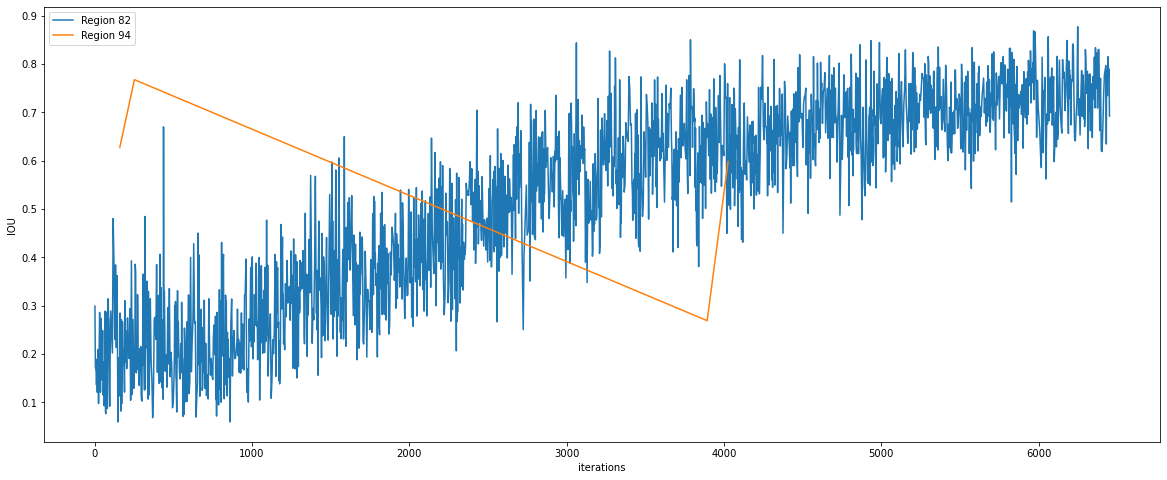

In [4]:
iters = []
IOU_value_82 = []
IOU_value_94 = []
IOU_value_106 = []

count = 0
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):

        if "Region 82" in line and count%10==0:
            
            IOU_value_82.append(float(line.strip().split(',')[0].split(' ')[4]))
            iters.append(count/10)
            
        if "Region 94" in line and count%10==0:
            
            IOU_value_94.append(float(line.strip().split(',')[0].split(' ')[4]))
     
        if "Region 106" in line and count%10==0:
            
            IOU_value_106.append(float(line.strip().split(',')[0].split(' ')[4]))
        
        count += 1
        
len_data = min(len(iters),len(IOU_value_82),len(IOU_value_94),len(IOU_value_106))
    
plt.figure(figsize=(20, 8))
sns.lineplot(iters[:len_data], IOU_value_82[:len_data], label='Region 82')
sns.lineplot(iters[:len_data], IOU_value_94[:len_data], label='Region 94')
sns.lineplot(iters[:len_data], IOU_value_106[:len_data], label='Region 106')
plt.xlabel("iterations")
plt.ylabel("IOU")

## Predicts

Predict one image

In [9]:
#!cd darknet && ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_1200.weights ../test.jpg -thresh 0.2

### Predict all images

#### Predict method 1

In [15]:
!cd darknet && ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg ../backup/yolov3_ih_fp_3600.weights <../metadata/test_list.txt> ../result.txt -thresh 0.1

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

#### Predict method 2

In [ ]:
#Donloading darnet.py only need to be run once
#!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

In [5]:
!cd darknet

In [6]:
from ctypes import *

In [7]:
lib = CDLL("darknet/libdarknet.so", RTLD_GLOBAL)
darknet_lib_path = os.path.join(os.getcwd(), "darknet", "libdarknet.so")
lib = CDLL(darknet_lib_path, RTLD_GLOBAL)

In [9]:
from darknet import *

In [10]:
threshold = 0.1

In [11]:
submit_file_path = "submission.json"
cfg_path_2 = os.path.join(CONFIG_PATH, "yolov3_ih_fp.cfg_test")
weight_path = os.path.join(BACKUP_PATH, "yolov3_ih_fp_3600.weights")

test_img_list_path = os.path.join(METADATA_PATH, "test_list.txt")

In [15]:
load_net = lib.load_network
load_meta = lib.get_metadata
load_image = lib.load_image_color

In [16]:
gpu_index = 0
net = load_net(cfg_path_2.encode(),
               weight_path.encode(), 
               gpu_index)
meta = load_meta(DATA_EXTENSION_FILE_PATH.encode())

In [17]:
submit_dict = {"ImageId": [], "PredictionString": []}
count = 0
with open(test_img_list_path, "r") as test_img_list_f:
    # tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        #print(line.strip().encode())
        if count > 50:
            break
            
        count +=1
        image_id = line.strip().split('/')[-1].strip().split('.')[0]
        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)
        submit_line = []
        for e in infer_result:

            label = e[0]
            confi = e[1]

            rw = e[2][2]
            rh = e[2][3]
            rcx = e[2][0]
            rcy = e[2][1]
           
            
            submit_line.append([confi, rcx, rcy, rw, rh])
        submit_dict["ImageId"].append(image_id)
        submit_dict["PredictionString"].append(submit_line)


pd.DataFrame(submit_dict).to_json(submit_file_path)

51it [00:03, 13.89it/s]


In [19]:
submissions = pd.read_json('submission.json')
submissions.set_index("ImageId", inplace=True)
submissions.head(10)

,PredictionString
ImageId,
f1a8eb8ec8d8d816,[]
c2a2d7a0d24bc7f8,[]
6ad3d128a23cf346,[]
42079c3a8d8ca8ce,[]
4ad11ff81db04676,[]
5bf94f371d7d758d,[]
2842bdc05d7c62bf,[]
b391063dd8f7c5b1,[]
6beae1f9a24bdcc4,[]


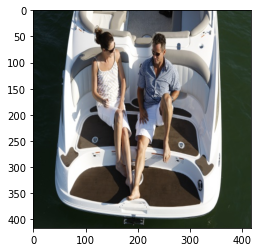

In [21]:
ex_image_id = 'f1a8eb8ec8d8d816'
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
df_predict = list(submissions['PredictionString'].loc[ex_image_id])

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
plt.ylim([416, 0])
plt.xlim([0,416])

for row in df_predict:
    print(row)
    confianza, rcx, rcy, rw, rh = [float(i) for i in row]
    x = rcx - rw/2
    y = rcy - rh/2
    w = rw
    h = rh
    
    xmin = max(0,x)
    xmax = min(x+w,416)
    ymin = max(0,y)
    ymax = min(y+h,416)
    
    #plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
    plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin])
    

In case you want to use the model with keras you need to download convert.py https://github.com/qqwweee/keras-yolo3/blob/master/convert.py

And then run the following command

In [22]:
#!python convert.py cfg/yolov3_ih_fp.cfg backup/yolov3_ih_fp_1200.weights yolov3.h5